## 1. Carga de datos y limpieza inicial

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
data_dir = 'results/'

In [3]:
#data = pd.read_csv(data_dir + 'GwasCat_associations.r2020-05-03.parsed.csv.gz')
data = pd.read_table(data_dir + 'gwas_cat.filtrado.tsv.gz')

In [4]:
data.head()

,fenotipo,alelo_riesgo,categoria_fenotipo,genes_reportados,genes_mapeados,contexto,OR_or_beta,gen_mapeado_elegido,EFO_URI
0,Crohn's disease,rs12722489-C,Digestive system disorder,IL2RA,IL2RA,intron,1.11,IL2RA,http://www.ebi.ac.uk/efo/EFO_0000384
1,Crohn's disease,rs151181-G,Digestive system disorder,IL27 | SH2B1 | EIF3C | LAT | CD19,CLN3 | AC138894.1,intron,1.07,CLN3,http://www.ebi.ac.uk/efo/EFO_0000384
2,Crohn's disease,rs2058660-G,Digestive system disorder,IL12RL2 | IL18R1 | IL1RL1 | IL18RAP,IL18RAP,intron,1.19,IL18RAP,http://www.ebi.ac.uk/efo/EFO_0000384
3,Crohn's disease,rs6556412-A,Digestive system disorder,IL12B,AC008691.1,intron,1.18,NaN,http://www.ebi.ac.uk/efo/EFO_0000384
4,Crohn's disease,rs2797685-A,Digestive system disorder,VAMP3,PER3 | Z98884.1,intron,1.05,PER3,http://www.ebi.ac.uk/efo/EFO_0000384


In [5]:
data.shape

(112626, 9)

In [6]:
data.categoria_fenotipo.unique()

array(['Digestive system disorder', 'Lipid or lipoprotein measurement',
       'Metabolic disorder', 'Cardiovascular measurement',
       'Immune system disorder', 'Biological process',
       'Cardiovascular disease', 'Cancer', 'Neurological disorder',
       'Other measurement', 'Body measurement', 'Other disease',
       'Other trait', 'Inflammatory measurement',
       'Hematological measurement', 'Response to drug',
       'Liver enzyme measurement', nan], dtype=object)

In [7]:
mask = data.categoria_fenotipo.isin(['Response to drug', 'Neurological disorder', 'Immune system disorder', 'Biological process'])
print(data.shape)
data = data[mask]
print(data.shape)

(112626, 9)
(20094, 9)


Seleccionamos aquellas instancias que tienen en la columna `alelo_riesgo` un SNP.

In [8]:
mask_snps = data.alelo_riesgo.str.match("^rs[0-9]+-[ATCG\?]$")
data = data[mask_snps]
data.shape

(19538, 9)

Miramos y descartamos valores faltantes

In [9]:
data.isna().sum()

fenotipo                  0
alelo_riesgo              0
categoria_fenotipo        0
genes_reportados       9138
genes_mapeados          145
contexto                145
OR_or_beta                0
gen_mapeado_elegido    8647
EFO_URI                   0
dtype: int64

No nos interesan aquellas instancias que tienen valore faltantes en la columna `OR_or_beta`

In [10]:
data.dropna(subset = ['OR_or_beta'], inplace = True)
data.shape

(19538, 9)

In [11]:
data.isna().sum()

fenotipo                  0
alelo_riesgo              0
categoria_fenotipo        0
genes_reportados       9138
genes_mapeados          145
contexto                145
OR_or_beta                0
gen_mapeado_elegido    8647
EFO_URI                   0
dtype: int64

#### ESTO SE PUEDE MEJORAR: tiene que haber una única componente gigante

**Opcional 1**: sacamos aquellos alelos que aparezcan una sola vez. Sirve más que nada para achicar la base de datos.

In [12]:
if False:
    umbral = 1
    mask_alelos_poca_frecuencia = data.alelo_riesgo.value_counts() <=1
    mask_alelos_poca_frecuencia.head()

    alelos_poca_frecuencia = list(mask_alelos_poca_frecuencia.index[mask_alelos_poca_frecuencia.values])
    print(len(alelos_poca_frecuencia))

    mask_descartables = data.alelo_riesgo.isin(alelos_poca_frecuencia)
    mask_descartables

    print(data.shape)
    data = data[~mask_descartables]
    print(data.shape)

**Opcional 2:** Sacamos aquellos fenotipos que aparecen una sola vez:

In [13]:
umbral = 1
mask_fenotipos_poca_frecuencia = data.fenotipo.value_counts() <=1
mask_fenotipos_poca_frecuencia.head()

Post bronchodilator FEV1/FVC ratio    False
General cognitive ability             False
Highest math class taken (MTAG)       False
Schizophrenia                         False
Self-reported math ability (MTAG)     False
Name: fenotipo, dtype: bool

In [14]:
fenotipos_poca_frecuencia = list(mask_fenotipos_poca_frecuencia.index[mask_fenotipos_poca_frecuencia.values])
print(len(fenotipos_poca_frecuencia))

121


In [15]:
mask_descartables = data.fenotipo.isin(fenotipos_poca_frecuencia)
mask_descartables

90        False
91        False
92        False
93        False
94        False
          ...  
112617    False
112618    False
112619    False
112620    False
112621    False
Name: fenotipo, Length: 19538, dtype: bool

In [16]:
print(data.shape)
data = data[~mask_descartables]
print(data.shape)

(19538, 9)
(19417, 9)


### 2. Tripletes `alelo_riesgo`, `fenotipo` y `OR_or_beta` - Matriz de utilidad/¿incidencia?

In [17]:
data_tripletes = data[['alelo_riesgo', 'fenotipo', 'OR_or_beta']]
data_tripletes.shape

(19417, 3)

In [18]:
data_tripletes

,alelo_riesgo,fenotipo,OR_or_beta
90,rs7779014-T,Multiple sclerosis,0.4800
91,rs17149161-A,Multiple sclerosis,1.8700
92,rs12644284-?,Multiple sclerosis,2.0400
93,rs7789940-G,Multiple sclerosis,1.8700
94,rs758944-T,Multiple sclerosis,0.4800
...,...,...,...
112617,rs6585426-T,Highest math class taken (MTAG),0.0129
112618,rs2629540-C,Highest math class taken (MTAG),0.0157
112619,rs4384309-A,Highest math class taken (MTAG),0.0110
112620,rs12761761-T,Highest math class taken (MTAG),0.0173


**Matriz de incidencia**

In [19]:
n_alelos = data_tripletes.alelo_riesgo.nunique()
n_fenotipos = data_tripletes.fenotipo.nunique()

data_bipartita = pd.DataFrame(np.zeros((n_alelos, n_fenotipos)), columns = data_tripletes.fenotipo.value_counts().index, dtype = np.int8)
data_bipartita.head()

,Post bronchodilator FEV1/FVC ratio,General cognitive ability,Highest math class taken (MTAG),Schizophrenia,Self-reported math ability (MTAG),Intelligence (MTAG),Self-reported math ability,Multiple sclerosis,Intelligence,Post bronchodilator FEV1/FVC ratio in COPD,...,Uncontrolled blood pressure in combination therapy (beta blocker and thiazide diuretic),Alloimmunization response to red blood cell transfusion in sickle cell anemia,Allergic dermatitis (nickel),Creutzfeldt-Jakob disease (sporadic),Ulcerative colitis or Crohn's disease,Obstructive sleep apnea,Childhood absence epilepsy,Blood pressure measurement (cold pressor test),Alloimmunization response to pregnancy (HLA class I),Response to opioid analgesics in cancer (pain decrease)
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
### EN EL DICCIONARIO APARECEN ORDENADOS POR FRECUENCIA
dict_id_to_alelo = {}
for i,alelo in enumerate(data_tripletes.alelo_riesgo.value_counts().index):
    dict_id_to_alelo[i] = alelo
    
dict_alelo_to_id = {v: k for k, v in dict_id_to_alelo.items()}

In [21]:
for _, row in data_tripletes.iterrows():
    alelo_row = row.alelo_riesgo
    fenotipo_row = row.fenotipo
    id_alelo = dict_alelo_to_id[alelo_row]
    data_bipartita.loc[id_alelo, fenotipo_row] = 1

**Chequeos**

La suma de todos los elementos de `data_bipartita` debe dar la cantidad de filas en `data_tripletes`

In [22]:
data_bipartita.sum().sum() == data_tripletes.shape[0]

True

La suma por columnas el `value_counts()` de `data_tripletes.fenotipo`

In [23]:
(data_tripletes.fenotipo.value_counts().values == data_bipartita.sum().values).all()

True

La suma por filas el `value_counts()` de `data_tripletes.alelo_riesgo`

In [24]:
(data_tripletes.alelo_riesgo.value_counts().values == data_bipartita.sum(axis = 1).values).all()

True

In [25]:
data_bipartita

,Post bronchodilator FEV1/FVC ratio,General cognitive ability,Highest math class taken (MTAG),Schizophrenia,Self-reported math ability (MTAG),Intelligence (MTAG),Self-reported math ability,Multiple sclerosis,Intelligence,Post bronchodilator FEV1/FVC ratio in COPD,...,Uncontrolled blood pressure in combination therapy (beta blocker and thiazide diuretic),Alloimmunization response to red blood cell transfusion in sickle cell anemia,Allergic dermatitis (nickel),Creutzfeldt-Jakob disease (sporadic),Ulcerative colitis or Crohn's disease,Obstructive sleep apnea,Childhood absence epilepsy,Blood pressure measurement (cold pressor test),Alloimmunization response to pregnancy (HLA class I),Response to opioid analgesics in cancer (pain decrease)
0,0,1,1,0,1,1,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,1,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,1,0,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17854,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17855,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17856,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
17857,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


**Distribución de grado para fenotipos**

(array([143., 159., 101.,  75.,  32.,  22.,  12.,   5.,   8.,   4.]),
 array([0.69314718, 1.36340462, 2.03366207, 2.70391951, 3.37417695,
        4.04443439, 4.71469184, 5.38494928, 6.05520672, 6.72546417,
        7.39572161]),
 <a list of 10 Patch objects>)

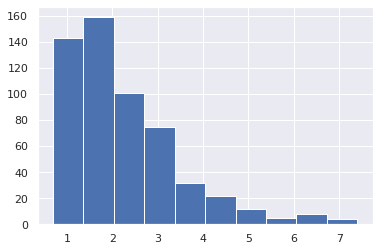

In [26]:
plt.hist(np.log(data_bipartita.sum()))

**Distribución de grado para alelos**

(array([1.6504e+04, 1.1920e+03, 0.0000e+00, 1.3200e+02, 0.0000e+00,
        2.5000e+01, 4.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([1. , 1.6, 2.2, 2.8, 3.4, 4. , 4.6, 5.2, 5.8, 6.4, 7. ]),
 <a list of 10 Patch objects>)

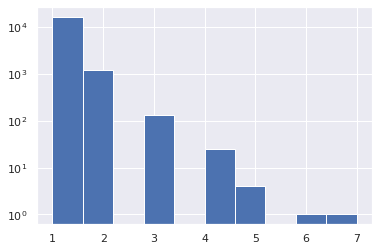

In [27]:
plt.hist(data_bipartita.sum(axis = 1), log=True)

### 3. Armamos la red --> ¿Pasar a Gephy la visualización?

Se puede saltear por ahora, no lo usamos

In [28]:
import networkx as nx

In [29]:
red = nx.Graph()

In [30]:
red.add_edges_from(data_tripletes[['alelo_riesgo', 'fenotipo']].values)

In [31]:
### MUY PESADO EN MEMORIA
# matriz_adyacencia = nx.to_pandas_adjacency(red, dtype = np.int8)
adj_matrix = nx.adjacency_matrix(red).toarray().astype(np.int8)
adj_matrix

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int8)

**Label Propagation**

In [32]:
import utils


In [43]:
todos_fenotipos = data_tripletes.fenotipo.unique()
todos_fenotipos

array(['Multiple sclerosis',
       'Alcohol consumption (transferrin glycosylation)',
       'Ulcerative colitis', 'Psoriasis', 'Nicotine dependence',
       "Alzheimer's disease", 'Schizophrenia',
       "Alzheimer's disease (late onset)", 'Prion diseases',
       'Rheumatoid arthritis', 'Restless legs syndrome',
       'Amyotrophic lateral sclerosis', 'Hoarding', 'Glaucoma',
       'Warfarin maintenance dose', 'Bipolar disorder',
       'Atopic dermatitis', 'Response to citalopram treatment', 'AIDS',
       'Major depressive disorder (broad)', 'Autism',
       'Response to antipsychotic treatment', "Parkinson's disease",
       'Attention deficit hyperactivity disorder', 'Alcohol dependence',
       'Major depressive disorder', 'Kawasaki disease',
       'Smoking behavior', 'Glaucoma (primary open-angle)',
       'Age-related macular degeneration', 'Permanent tooth development',
       'Response to statin therapy', 'Tourette syndrome',
       'Bipolar disorder and schizophrenia',
  

In [53]:
print('Intelligence' in todos_fenotipos)
nodos_entrada = ['Intelligence']


True


In [54]:
labels = [
    0 if nodo in nodos_entrada else -1
    for nodo in red.nodes()
]
# print(labels)

In [55]:
import torch

# Create input tensors
adj_matrix_t = torch.FloatTensor(adj_matrix)
labels_t = torch.LongTensor(labels)

In [69]:
# Label Spreading
label_spreading = utils.LabelSpreading(adj_matrix_t)
print("Label Spreading: ", end="")
label_spreading.fit(labels_t, alpha=0.95)


Label Spreading: The method stopped after 196 iterations, variation=0.0010.


In [70]:
prediction_raw_values = np.array(label_spreading.predictions.tolist()).flatten()
# prediction_log_values = np.log10(prediction_raw_values)
# prediction_raw_values[:100]

In [71]:
prendidos_fenotipo = pd.DataFrame(columns = ['fenotipo', 'prediccion'])
prendidos_fenotipo['fenotipo'] = list(red.nodes())
prendidos_fenotipo['prediccion'] = prediction_raw_values
prendidos_fenotipo.sort_values(by = 'prediccion', inplace = True, ascending = False)
prendidos_fenotipo

,fenotipo,prediccion
506,Intelligence,0.241746
8029,Intelligence (MTAG),0.071122
8054,General cognitive ability,0.067245
16341,Highest math class taken (MTAG),0.021292
16174,Self-reported math ability (MTAG),0.014859
...,...,...
4685,rs57504626-?,0.000000
4684,rs7810240-?,0.000000
4683,rs80147136-?,0.000000
4682,rs75639901-?,0.000000


In [72]:
mask = prendidos_fenotipo.fenotipo.isin(todos_fenotipos)
prendidos_fenotipo = prendidos_fenotipo[mask]

In [73]:
prendidos_fenotipo.nlargest(20, columns = ['prediccion'])

,fenotipo,prediccion
506,Intelligence,0.241746
8029,Intelligence (MTAG),0.071122
8054,General cognitive ability,0.067245
16341,Highest math class taken (MTAG),0.021292
16174,Self-reported math ability (MTAG),0.014859
16509,Self-reported math ability,0.009240
16295,Highest math class taken,0.008237
14904,Extremely high intelligence,0.007585
8910,General risk tolerance (MTAG),0.003972
12403,Autism and major depressive disorder (MTAG),0.003813


In [ ]:
data_bipartita

### 4. Filtro Colaborativo Implícito

https://medium.com/radon-dev/item-item-collaborative-filtering-with-binary-or-unary-data-e8f0b465b2c3

In [32]:
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse

En primer lugar, normalizamos con respecto a la cantidad de enlaces que tiene cada alelo. En las películas, esto se justifica como 

> *This is the idea of normalizing the user vectors so that a user with many ratings contributes less to any individual rating. This is to say that a like from a user who has only liked 10 items is more valuable to us than a like from someone who likes everything she comes across.*

In [33]:
#------------------------
# ITEM-ITEM CALCULATIONS
#------------------------

# As a first step we normalize the user vectors to unit vectors.

# magnitude = sqrt(x2 + y2 + z2 + ...)
magnitude = np.sqrt(np.square(data_bipartita_train).sum(axis=1))

# # unitvector = (x / magnitude, y / magnitude, z / magnitude, ...)
data_bipartita_normalizada = data_bipartita_train.divide(magnitude, axis='index')
data_bipartita_normalizada

,Blood protein levels,Heel bone mineral density,Height,Metabolite levels,Educational attainment (years of education),Body mass index,Post bronchodilator FEV1/FVC ratio,Educational attainment (MTAG),General cognitive ability,Post bronchodilator FEV1,...,Food addiction,Life threatening arrhythmia,Incident coronary heart disease,CXCL5 levels,Triglyceride levels x short total sleep time interaction (1df test),Developmental language disorder (syntactic complexity),Lobe attachment,Femoral neck length,Sleep depth,Sepsis from pneumonia (survival)
0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.2,0.000000,0.0,0.2,0.2,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.2,0.0,0.0,0.0,0.0,0.200000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89454,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89455,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89456,0.0,0.0,0.0,1.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
89457,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Luego,calculamos la similaridad coseno para cada columna, obteniendo así qué fenotipos son parecidos.

In [34]:
def calculate_similarity(data_items):
    """Calculate the column-wise cosine similarity for a sparse
    matrix. Return a new dataframe matrix with similarities.
    """
    data_sparse = sparse.csr_matrix(data_items)
    similarities = cosine_similarity(data_sparse.transpose())
    sim = pd.DataFrame(data=similarities, index= data_items.columns, columns= data_items.columns)
    return sim

# Build the similarity matrix
data_matrix = calculate_similarity(data_bipartita_normalizada)
data_matrix.head()

,Blood protein levels,Heel bone mineral density,Height,Metabolite levels,Educational attainment (years of education),Body mass index,Post bronchodilator FEV1/FVC ratio,Educational attainment (MTAG),General cognitive ability,Post bronchodilator FEV1,...,Food addiction,Life threatening arrhythmia,Incident coronary heart disease,CXCL5 levels,Triglyceride levels x short total sleep time interaction (1df test),Developmental language disorder (syntactic complexity),Lobe attachment,Femoral neck length,Sleep depth,Sepsis from pneumonia (survival)
Blood protein levels,1.000000,0.000000,0.000444,0.000000,0.000000,0.000685,0.00014,0.000000,0.000000,0.000522,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Heel bone mineral density,0.000000,1.000000,0.002303,0.000240,0.000189,0.000173,0.00000,0.000585,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Height,0.000444,0.002303,1.000000,0.000078,0.000323,0.000754,0.00022,0.000399,0.000000,0.000274,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Metabolite levels,0.000000,0.000240,0.000078,1.000000,0.000336,0.000000,0.00000,0.000000,0.000353,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Educational attainment (years of education),0.000000,0.000189,0.000323,0.000336,1.000000,0.001954,0.00000,0.282639,0.003331,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Veamos similaridades

In [35]:
# Lets get the top 11 similar artists for Beyonce
# print(data_matrix.loc['Drinking behavior'].nlargest(25))

print(data_matrix.loc['Educational attainment (MTAG)'].nlargest(30))

Educational attainment (MTAG)                                                     1.000000
Educational attainment (years of education)                                       0.282639
Highest math class taken (MTAG)                                                   0.148647
Cognitive performance (MTAG)                                                      0.063614
Self-reported math ability (MTAG)                                                 0.021143
Intelligence (MTAG)                                                               0.011440
Household income (MTAG)                                                           0.010186
Cognitive performance                                                             0.008250
Intelligence                                                                      0.007049
Highest math class taken                                                          0.006974
Urea levels                                                                       0.004795

Construimos una nueva matriz, con los `n_neighbours` de cada fenotipo. Vendrían a ser los `n_neighbours` fenotipos más cercanos a cada fenotipos.

In [36]:
n_neighbours = 20
data_neighbours = pd.DataFrame(index=data_matrix.columns, columns=range(1,n_neighbours+1))
for i in range(0, len(data_matrix.columns)):
    data_neighbours.iloc[i,:n_neighbours] = data_matrix.iloc[0:,i].sort_values(ascending=False)[:n_neighbours].index
data_neighbours.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
Blood protein levels,Blood protein levels,Planum temporale asymmetry index,Soluble levels of adhesion molecules,L-arginine levels,Insulinogenic index,Neovascular age-related macular degeneration,NT-proBNP levels in acute coronary syndrome,ADAMTS13 activity,B-type natriuretic peptide levels,Neonatal cytokine/chemokine levels (fetal gene...,Butyrylcholinesterase levels,Vitamin B12 levels,Blood protein levels in cardiovascular risk,Expressive vocabulary in infants,Metabolic traits,Age-related macular degeneration (choroidal ne...,HIV-1 susceptibility,Composite immunoglobulin trait (IgA/IgG),Serum cancer antigen 19.9 levels,Serum protein levels (sST2)
Heel bone mineral density,Heel bone mineral density,Serum sclerostin levels,Fractures,Thyroid function,Systolic blood pressure change trajectories,Serum urea levels,Multisite chronic pain,Femoral neck bone mineral density,Cardiovascular disease risk factors,Total body bone mineral density,Systemic lupus erythematosus or rheumatoid art...,Height,Maternal nondisjunction of chromosome 21 (MI e...,Heel bone mineral density (MTAG),Total body bone mineral density (MTAG),Serum alkaline phosphatase levels,Stem cell factor levels,Lumbar spine bone mineral density (trabecular),Maternal nondisjunction of chromosome 21 (moth...,Educational attainment (college completion)
Height,Height,Infant length,Birth length,Hip circumference adjusted for BMI,Puberty onset (breast development),Waist circumference adjusted for BMI in non-sm...,Glucagon levels in response to oral glucose to...,Waist circumference adjusted for BMI (adjusted...,Developmental dysplasia of the hip,Birth weight,Waist circumference adjusted for BMI in active...,Age at voice drop,Anthropometric traits,Head circumference (infant),Infant head circumference (MTAG),Weight,Waist circumference adjusted for body mass index,Body fat distribution (arm fat ratio),Menarche and menopause (age at onset),Birth weight (MTAG)
Metabolite levels,Metabolite levels,Parkinson's disease in GBA mutation carriers,Statin-induced myopathy (severe),Red blood cell fatty acid levels,Serum urea levels,Acylcarnitine levels,Urinary sodium to creatinine ratio,Plasma factor V levels in venous thrombosis (c...,Lipoprotein-associated phospholipase A2 activi...,Plasma free amino acid levels (adjusted for tw...,Fasting blood glucose,Folate pathway vitamin levels,Change in serum metabolite levels,QRS interval (sulfonylurea treatment interaction),Hematological and biochemical traits,Change in serum metabolite levels (CMS),Serum metabolite levels,Alanine transaminase levels,Total bilirubin levels in HIV-1 infection,Age-related hearing impairment
Educational attainment (years of education),Educational attainment (years of education),Educational attainment (MTAG),Highest math class taken (MTAG),Cognitive performance (MTAG),Household income (MTAG),Intelligence (MTAG),Self-reported math ability (MTAG),Educational attainment (college completion),Autism and major depressive disorder (MTAG),Risk-taking tendency (4-domain principal compo...,Household income,Smoking behaviour (cigarette pack-years),Intelligence,Urea levels,Cigarettes smoked per day (MTAG),Regular attendance at a gym or sports club,Eating disorders,Alcohol consumption,Educational attainment,Highest math class taken


Elegimos un alelo dentro del conjunto de entrenamiento

In [85]:
# np.random.seed(43)
alelo_prueba = np.random.choice(data_tripletes.alelo_riesgo.unique())
# alelo_prueba = 'rs6739779-C'
# alelo_prueba = 'rs4549631-C'
print(f'Alelo de prueba: {alelo_prueba}')

alelo_prueba_index = dict_alelo_to_id[alelo_prueba]
print(f'Indice del alelo de prueba: {alelo_prueba_index}')

known_alelo_fenotipos = data_bipartita_normalizada.iloc[alelo_prueba_index]
known_alelo_fenotipos = known_alelo_fenotipos[known_alelo_fenotipos >0].index.values
print(f'Fenotipos asociados al alelo: {known_alelo_fenotipos}')

Alelo de prueba: rs1582888-G
Indice del alelo de prueba: 58910
Fenotipos asociados al alelo: ['Neuroticism']


Dado esos fenotipos, seleccionamos los similares a partir de `data_neighbours`

In [58]:
# Construct the neighbourhood from the most similar items to the
# ones our alelo it's related
most_similar_fenotipos = data_neighbours.loc[known_alelo_fenotipos]
# most_similar_fenotipos
similar_list = most_similar_fenotipos.values.tolist()
similar_list = list(set([item for sublist in similar_list for item in sublist]))
print(f'Fenotipos similares, sin rankear: {similar_list}')

Fenotipos similares, sin rankear: ['Infant head circumference (MTAG)', 'Height', 'Hip circumference adjusted for BMI', 'Menarche and menopause (age at onset)', 'Developmental dysplasia of the hip', 'Age at voice drop', 'Birth weight (MTAG)', 'Head circumference (infant)', 'Infant length', 'Waist circumference adjusted for BMI in active individuals', 'Birth weight', 'Body fat distribution (arm fat ratio)', 'Glucagon levels in response to oral glucose tolerance test (fasting)', 'Waist circumference adjusted for BMI in non-smokers', 'Anthropometric traits', 'Birth length', 'Waist circumference adjusted for body mass index', 'Waist circumference adjusted for BMI (adjusted for smoking behaviour)', 'Puberty onset (breast development)', 'Weight']


Seleccionamos, dentro de la matriz de similaridades, los valores para los fenotipos similares

In [59]:
neighbourhood = data_matrix[similar_list].loc[similar_list]
neighbourhood.shape

(20, 20)

Creamos un vector que tiene los fenotipos similares, incluyendo los conocidos, y su *rating* (1 o 0).

In [60]:
# A user vector containing only the neighbourhood items and
# the known user likes.
fenotipos_probables = data_bipartita_normalizada.iloc[alelo_prueba_index].loc[similar_list]
fenotipos_probables

Infant head circumference (MTAG)                                         0.0
Height                                                                   1.0
Hip circumference adjusted for BMI                                       0.0
Menarche and menopause (age at onset)                                    0.0
Developmental dysplasia of the hip                                       0.0
Age at voice drop                                                        0.0
Birth weight (MTAG)                                                      0.0
Head circumference (infant)                                              0.0
Infant length                                                            0.0
Waist circumference adjusted for BMI in active individuals               0.0
Birth weight                                                             0.0
Body fat distribution (arm fat ratio)                                    0.0
Glucagon levels in response to oral glucose tolerance test (fasting)     0.0

Calculamos los scores y ordenamos.

In [61]:
# Calculate the score.
score = neighbourhood.dot(fenotipos_probables).div(neighbourhood.sum(axis=1))
# score
score.sort_values(ascending = False, inplace = True)
# score

E imprimimos los fenotipos conocidos y el ranking

In [62]:
print(known_alelo_fenotipos)
print(score)

['Height']
Height                                                                   0.885609
Infant length                                                            0.012447
Birth length                                                             0.011264
Hip circumference adjusted for BMI                                       0.009593
Puberty onset (breast development)                                       0.009257
Glucagon levels in response to oral glucose tolerance test (fasting)     0.007059
Developmental dysplasia of the hip                                       0.006945
Age at voice drop                                                        0.006307
Birth weight                                                             0.005907
Anthropometric traits                                                    0.005720
Waist circumference adjusted for BMI in non-smokers                      0.005237
Waist circumference adjusted for BMI in active individuals               0.005149
Waist

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text xticklabel objects>)

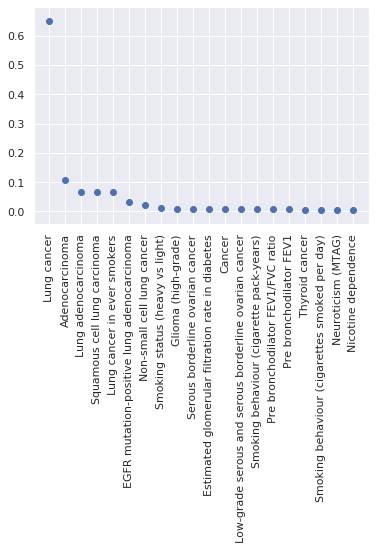

In [43]:
# sns.barplot(score.index, score.values)
plt.scatter(score.index, score.values)
plt.xticks(rotation = 90)

In [ ]:
def recomendaciones_alelo(alelo_index, data_bipartita_normalizada, data_neighbours, data_matrix):
    known_alelo_fenotipos = data_bipartita_normalizada.iloc[alelo_index]
    known_alelo_fenotipos = known_alelo_fenotipos[known_alelo_fenotipos >0].index.values

    most_similar_fenotipos = data_neighbours.loc[known_alelo_fenotipos]

    similar_list = most_similar_fenotipos.values.tolist()
    similar_list = list(set([item for sublist in similar_list for item in sublist]))

    neighbourhood = data_matrix[similar_list].loc[similar_list]

    fenotipos_probables = data_bipartita_normalizada.iloc[alelo_prueba_index].loc[similar_list]

    score = neighbourhood.dot(fenotipos_probables).div(neighbourhood.sum(axis=1))
    score.sort_values(ascending = False, inplace = True)

    return score

In [ ]:
score = recomendaciones_alelo(alelo_prueba_index, data_bipartita_normalizada, data_neighbours, data_matrix)

In [ ]:
plt.scatter(score.index, score.values)
plt.xticks(rotation = 90)

### Sobre Conjunto de Test

"A mano" por ahora

In [130]:
# np.random.seed(50)
alelo_prueba_index = np.random.choice(data_bipartita_test_1.index)
print(f'Indice alelo a probar: {alelo_prueba_index}')

alelo_prueba = dict_id_to_alelo[alelo_prueba_index]
print(f'Alelo a probar: {alelo_prueba}')

known_alelo_fenotipos = data_bipartita_test_1.loc[alelo_prueba_index]
known_alelo_fenotipos = known_alelo_fenotipos[known_alelo_fenotipos >0].index.values
print(f'Fenotipos asociados al alelo para generar recomendaciones: {known_alelo_fenotipos}')

Indice alelo a probar: 3182
Alelo a probar: rs117799466-C
Fenotipos asociados al alelo para generar recomendaciones: ['Educational attainment (years of education)']


In [131]:
fenotipos_reportados_alelo = data_bipartita.loc[alelo_prueba_index]
fenotipos_reportados_alelo = fenotipos_reportados_alelo[fenotipos_reportados_alelo >0].index.values
print(f'Todos fenotipos asociados al alelo: {fenotipos_reportados_alelo}')

Todos fenotipos asociados al alelo: ['Educational attainment (years of education)'
 'Educational attainment (MTAG)' 'Schizophrenia']


In [132]:
most_similar_fenotipos = data_neighbours.loc[known_alelo_fenotipos]
similar_list = most_similar_fenotipos.values.tolist()
similar_list = list(set([item for sublist in similar_list for item in sublist]))
neighbourhood = data_matrix[similar_list].loc[similar_list]

In [133]:
fenotipos_probables = data_bipartita_test_1.loc[alelo_prueba_index].loc[similar_list]
# fenotipos_probables

In [134]:
score = neighbourhood.dot(fenotipos_probables).div(neighbourhood.sum(axis=1))
score.sort_values(ascending = False, inplace = True)
print(known_alelo_fenotipos)
print(fenotipos_reportados_alelo)
print(score.nlargest(50))

['Educational attainment (years of education)']
['Educational attainment (years of education)'
 'Educational attainment (MTAG)' 'Schizophrenia']
Educational attainment (years of education)                  0.673563
Educational attainment (MTAG)                                0.180552
Highest math class taken (MTAG)                              0.044344
Cognitive performance (MTAG)                                 0.026634
Household income (MTAG)                                      0.014558
Intelligence (MTAG)                                          0.013510
Self-reported math ability (MTAG)                            0.009243
Educational attainment (college completion)                  0.008480
Autism and major depressive disorder (MTAG)                  0.004336
Risk-taking tendency (4-domain principal component model)    0.004276
Smoking behaviour (cigarette pack-years)                     0.003938
Urea levels                                                  0.003849
Cigarettes smok

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text xticklabel objects>)

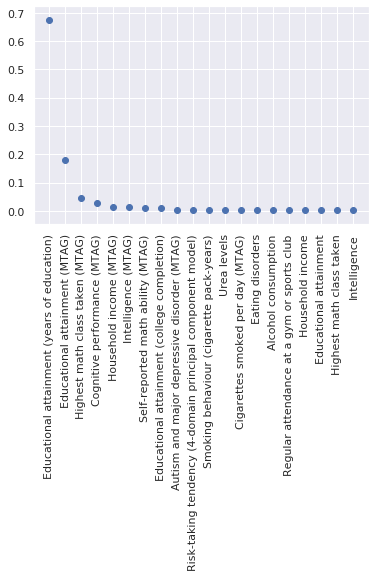

In [135]:
plt.scatter(score.index, score.values)
plt.xticks(rotation = 90)

1. grafico de fenotipos vs score
1. capacidad de priorizar dado 
1. Usar el paper de zhou


MARTES - 5 min
dimensión de los datos
encuadrar el problema biológico o metodológico



In [136]:
def indices_aciertos(fenotipos_recomendados, fenotipos_a_evaluar):
    indices = []
    for fenotipo in fenotipos_a_evaluar:
        if fenotipo in fenotipos_recomendados:
            indices.append(fenotipos_recomendados.index(fenotipo))
        else:
            indices.append(-1)
    return indices

In [137]:
n = 10
fenotipos_recomendados = list(score.index)
fenotipos_usados_para_recomendar = known_alelo_fenotipos
fenotipos_conocidos = fenotipos_reportados_alelo

n_0 = len(fenotipos_usados_para_recomendar)
fenotipos_recomendados = fenotipos_recomendados[n_0:n_0+n]
fenotipos_a_evaluar = [x for x in fenotipos_conocidos if x not in fenotipos_usados_para_recomendar]

indices_aciertos(fenotipos_recomendados, fenotipos_a_evaluar)

[0, -1]

In [114]:
n = 10

resultados = []

for alelo_prueba_index in data_bipartita_test_1.index:
#     print(alelo_prueba_index)
    alelo_prueba = dict_id_to_alelo[alelo_prueba_index]
    known_alelo_fenotipos = data_bipartita_test_1.loc[alelo_prueba_index]
    known_alelo_fenotipos = known_alelo_fenotipos[known_alelo_fenotipos >0].index.values
#     print(f'Fenotipos asociados al alelo para generar recomendaciones: {known_alelo_fenotipos}')
    
    fenotipos_reportados_alelo = data_bipartita.loc[alelo_prueba_index]
    fenotipos_reportados_alelo = fenotipos_reportados_alelo[fenotipos_reportados_alelo >0].index.values
#     print(f'Todos fenotipos asociados al alelo: {fenotipos_reportados_alelo}')
    
    most_similar_fenotipos = data_neighbours.loc[known_alelo_fenotipos]
    similar_list = most_similar_fenotipos.values.tolist()
    similar_list = list(set([item for sublist in similar_list for item in sublist]))
    neighbourhood = data_matrix[similar_list].loc[similar_list]
    
    fenotipos_probables = data_bipartita_test_1.loc[alelo_prueba_index].loc[similar_list]
    score = neighbourhood.dot(fenotipos_probables).div(neighbourhood.sum(axis=1))
    score.sort_values(ascending = False, inplace = True)
#     print(score.nlargest(5))

    
    fenotipos_recomendados = list(score.index)
    fenotipos_usados_para_recomendar = known_alelo_fenotipos
    fenotipos_conocidos = fenotipos_reportados_alelo
    
    n_0 = len(fenotipos_usados_para_recomendar)
    fenotipos_recomendados = fenotipos_recomendados[n_0:n_0+n]
    fenotipos_a_evaluar = [x for x in fenotipos_conocidos if x not in fenotipos_usados_para_recomendar]
    
    idxs = indices_aciertos(fenotipos_recomendados, fenotipos_a_evaluar)
    
    resultados_alelo = dict(zip(fenotipos_a_evaluar, idxs))
    resultados_alelo['alelo'] = alelo_prueba
    resultados_alelo['indice_alelo'] = alelo_prueba_index
    resultados.append(resultados_alelo)
    
#     print(idxs)


In [115]:
resultados_df = pd.DataFrame(resultados).set_index('indice_alelo')
resultados_df.head()

,Endometrial cancer,Prostate-specific antigen levels,alelo,Lumbar spine bone mineral density,Fractures,Bone mineral density,Cognitive performance (MTAG),Cognitive performance,HDL cholesterol,Triglycerides,...,Mean diameter of HDL particles,Basophil percentage of granulocytes,Smoking status (ever vs never smokers),Fasting plasma glucose,Eosinophil percentage of granulocytes,Glioblastoma,Family history of Alzheimer's disease,Maternal history of Alzheimer's disease,Medication use (antithrombotic agents),Thrombosis
indice_alelo,,,,,,,,,,,,,,,,,,,,,
2744,0.0,-1.0,rs11263761-A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1413,NaN,NaN,rs3736228-T,-1.0,-1.0,-1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2997,NaN,NaN,rs72906064-T,NaN,NaN,NaN,5.0,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1956,NaN,NaN,rs2602836-A,NaN,NaN,NaN,NaN,NaN,1.0,-1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2097,NaN,NaN,rs174555-C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
indices = resultados_df.drop(columns = 'alelo').values
indices = indices[~np.isnan(indices)]
plt.hist(indices, bins = np.arange(-1.5,9.5))

In [ ]:
print(f'Porcentaje aciertos: {(indices>-1).sum()/indices.size}')
print(f'Porcentaje no aciertos: {(indices==-1).sum()/indices.size}')

### Cosas para hacer

1. Chequear sobre `categoria_fenotipo` que no sea trivial
1. Agregar segunda forma de evaluación: borrando '1' de la matriz de train
1. Chequear que al separar train y test no se rompa la red
1. Metodizar la evaluación para obtener una métrica
1. Chequear que no estemos cayendo en la parte "fácil" de la red --> ¿pregunta biológica?